In [ ]:
import keras
keras.__version__

'2.4.3'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

data_dir = '/content/gdrive/MyDrive/ML Assignment 4'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')


f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

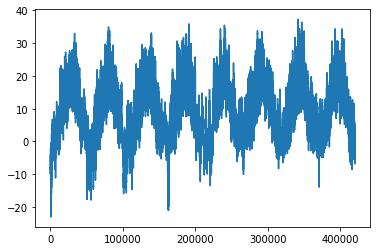

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

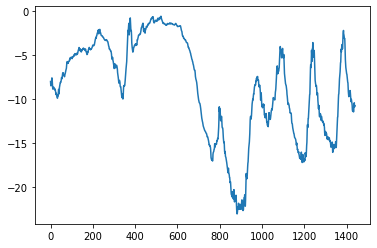

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

## Preparing Data

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## Machine Learning Baseline

In [ ]:
np.mean(np.abs(preds - targets))

NameError: ignored

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## Basic ML Approach

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 17s 32ms/step - loss: 2.4982 - val_loss: 1.0762
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.8646 - val_loss: 0.3522
Epoch 3/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3507 - val_loss: 0.3064
Epoch 4/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2802 - val_loss: 0.3200
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2613 - val_loss: 0.3009
Epoch 6/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2467 - val_loss: 0.3394
Epoch 7/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2423 - val_loss: 0.3127
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2341 - val_loss: 0.3296
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2308 - val_loss: 0.3441
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.224

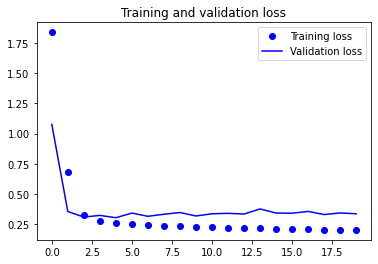

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Basic Recurrent Layer

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 86s 168ms/step - loss: 0.3486 - val_loss: 0.2742
Epoch 2/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2898 - val_loss: 0.2674
Epoch 3/20
500/500 [==============================] - 84s 169ms/step - loss: 0.2797 - val_loss: 0.2619
Epoch 4/20
500/500 [==============================] - 86s 172ms/step - loss: 0.2728 - val_loss: 0.2649
Epoch 5/20
500/500 [==============================] - 84s 169ms/step - loss: 0.2673 - val_loss: 0.2657
Epoch 6/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2601 - val_loss: 0.2617
Epoch 7/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2565 - val_loss: 0.2636
Epoch 8/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2499 - val_loss: 0.2658
Epoch 9/20
500/500 [==============================] - 85s 170ms/step - loss: 0.2465 - val_loss: 0.2659
Epoch 10/20
500/500 [==============================] - 85s 170ms/step - l

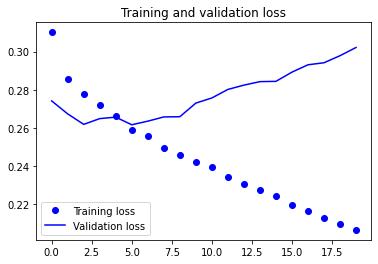

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Recurrent with Dropout

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 142s 280ms/step - loss: 0.3449 - val_loss: 0.2808
Epoch 2/40
500/500 [==============================] - 139s 279ms/step - loss: 0.3081 - val_loss: 0.2875
Epoch 3/40
500/500 [==============================] - 139s 277ms/step - loss: 0.3024 - val_loss: 0.2691
Epoch 4/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2971 - val_loss: 0.2840
Epoch 5/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2917 - val_loss: 0.2705
Epoch 6/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2888 - val_loss: 0.2759
Epoch 7/40
500/500 [==============================] - 139s 278ms/step - loss: 0.2832 - val_loss: 0.2723
Epoch 8/40
500/500 [==============================] - 139s 279ms/step - loss: 0.2826 - val_loss: 0.2712
Epoch 9/40
500/500 [==============================] - 139s 279ms/step - loss: 0.2750 - val_loss: 0.2702
Epoch 10/40
500/500 [==============================] - 139s 279m

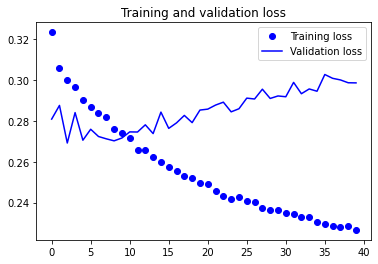

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Stacking Recurrent Layers

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 393s 776ms/step - loss: 0.3426 - val_loss: 0.2803
Epoch 2/20
500/500 [==============================] - 387s 774ms/step - loss: 0.3045 - val_loss: 0.2827
Epoch 3/20
500/500 [==============================] - 388s 776ms/step - loss: 0.2955 - val_loss: 0.2731
Epoch 4/20
500/500 [==============================] - 390s 780ms/step - loss: 0.2886 - val_loss: 0.2753
Epoch 5/20
500/500 [==============================] - 388s 776ms/step - loss: 0.2778 - val_loss: 0.2752
Epoch 6/20
500/500 [==============================] - 389s 779ms/step - loss: 0.2743 - val_loss: 0.2739
Epoch 7/20
500/500 [==============================] - 390s 781ms/step - loss: 0.2686 - val_loss: 0.2727
Epoch 8/20
500/500 [==============================] - 394s 789ms/step - loss: 0.2633 - val_loss: 0.2690
Epoch 9/20
500/500 [==============================] - 400s 801ms/step - loss: 0.2599 - val_loss: 0.2850
Epoch 10/20
500/500 [==============================] - 394s 788m

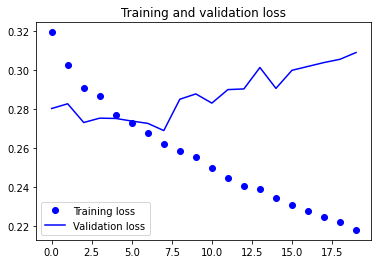

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Bidirectional RNN

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 88s 173ms/step - loss: 0.4950 - val_loss: 0.4853
Epoch 2/20
500/500 [==============================] - 84s 168ms/step - loss: 0.4526 - val_loss: 0.4535
Epoch 3/20
500/500 [==============================] - 84s 169ms/step - loss: 0.3899 - val_loss: 0.4308
Epoch 4/20
500/500 [==============================] - 85s 171ms/step - loss: 0.3515 - val_loss: 0.3763
Epoch 5/20
500/500 [==============================] - 85s 169ms/step - loss: 0.3292 - val_loss: 0.3705
Epoch 6/20
500/500 [==============================] - 85s 169ms/step - loss: 0.3174 - val_loss: 0.3609
Epoch 7/20
500/500 [==============================] - 86s 171ms/step - loss: 0.3027 - val_loss: 0.3568
Epoch 8/20
500/500 [==============================] - 84s 168ms/step - loss: 0.2918 - val_loss: 0.3474
Epoch 9/20
500/500 [==============================] - 88s 177ms/step - loss: 0.2819 - val_loss: 0.3450
Epoch 10/20
500/500 [==============================] - 86s 172ms/step - l

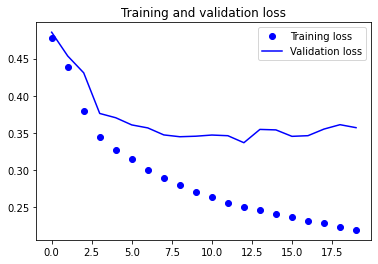

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 148s 289ms/step - loss: 0.3234 - val_loss: 0.2741
Epoch 2/20
500/500 [==============================] - 145s 289ms/step - loss: 0.2773 - val_loss: 0.2736
Epoch 3/20
500/500 [==============================] - 143s 287ms/step - loss: 0.2695 - val_loss: 0.2668
Epoch 4/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2653 - val_loss: 0.2645
Epoch 5/20
500/500 [==============================] - 144s 289ms/step - loss: 0.2598 - val_loss: 0.2747
Epoch 6/20
500/500 [==============================] - 146s 292ms/step - loss: 0.2541 - val_loss: 0.2720
Epoch 7/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2460 - val_loss: 0.2703
Epoch 8/20
500/500 [==============================] - 144s 287ms/step - loss: 0.2416 - val_loss: 0.2752
Epoch 9/20
500/500 [==============================] - 144s 288ms/step - loss: 0.2331 - val_loss: 0.2725
Epoch 10/20
500/500 [==============================] - 144s 288m

## Adjusting Units in Recurrent Layers

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(16,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 270s 530ms/step - loss: 0.3509 - val_loss: 0.2831
Epoch 2/20
500/500 [==============================] - 269s 538ms/step - loss: 0.3088 - val_loss: 0.2756
Epoch 3/20
500/500 [==============================] - 270s 541ms/step - loss: 0.3043 - val_loss: 0.2738
Epoch 4/20
500/500 [==============================] - 267s 533ms/step - loss: 0.2981 - val_loss: 0.2829
Epoch 5/20
500/500 [==============================] - 267s 534ms/step - loss: 0.2941 - val_loss: 0.2721
Epoch 6/20
500/500 [==============================] - 262s 524ms/step - loss: 0.2917 - val_loss: 0.2734
Epoch 7/20
500/500 [==============================] - 262s 524ms/step - loss: 0.2884 - val_loss: 0.2728
Epoch 8/20
500/500 [==============================] - 263s 527ms/step - loss: 0.2827 - val_loss: 0.2740
Epoch 9/20
500/500 [==============================] - 263s 526ms/step - loss: 0.2801 - val_loss: 0.2752
Epoch 10/20
500/500 [==============================] - 264s 528m

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(128, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
500/500 [==============================] - 857s 2s/step - loss: 0.3287 - val_loss: 0.2844
Epoch 2/10
500/500 [==============================] - 854s 2s/step - loss: 0.2998 - val_loss: 0.2705
Epoch 3/10
500/500 [==============================] - 847s 2s/step - loss: 0.2854 - val_loss: 0.2750
Epoch 4/10
500/500 [==============================] - 850s 2s/step - loss: 0.2764 - val_loss: 0.2683
Epoch 5/10
500/500 [==============================] - 852s 2s/step - loss: 0.2629 - val_loss: 0.2757
Epoch 6/10
500/500 [==============================] - 854s 2s/step - loss: 0.2538 - val_loss: 0.2855
Epoch 7/10
500/500 [==============================] - 851s 2s/step - loss: 0.2407 - val_loss: 0.2877
Epoch 8/10
500/500 [==============================] - 846s 2s/step - loss: 0.2330 - val_loss: 0.2862
Epoch 9/10
500/500 [==============================] - 849s 2s/step - loss: 0.2233 - val_loss: 0.2985
Epoch 10/10
500/500 [==============================] - 846s 2s/step - loss: 0.2157 - val_lo

## Swapping LSTM for GRU

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.LSTM(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 460s 910ms/step - loss: 0.3654 - val_loss: 0.2856
Epoch 2/20
500/500 [==============================] - 455s 909ms/step - loss: nan - val_loss: nan
Epoch 3/20
500/500 [==============================] - 459s 918ms/step - loss: nan - val_loss: nan
Epoch 4/20
500/500 [==============================] - 458s 916ms/step - loss: nan - val_loss: nan
Epoch 5/20
500/500 [==============================] - 458s 917ms/step - loss: nan - val_loss: nan
Epoch 6/20
500/500 [==============================] - 459s 919ms/step - loss: nan - val_loss: nan
Epoch 7/20
500/500 [==============================] - 459s 919ms/step - loss: nan - val_loss: nan
Epoch 8/20
500/500 [==============================] - 458s 917ms/step - loss: nan - val_loss: nan
Epoch 9/20
500/500 [==============================] - 457s 915ms/step - loss: nan - val_loss: nan
Epoch 10/20
500/500 [==============================] - 458s 916ms/step - loss: nan - val_loss: nan
Epoch 11/20
5

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 165s 325ms/step - loss: 0.3604 - val_loss: 0.2726
Epoch 2/20
500/500 [==============================] - 162s 325ms/step - loss: 0.2926 - val_loss: 0.2783
Epoch 3/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2840 - val_loss: 0.2805
Epoch 4/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2776 - val_loss: 0.2680
Epoch 5/20
500/500 [==============================] - 163s 327ms/step - loss: 0.2715 - val_loss: 0.2727
Epoch 6/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2656 - val_loss: 0.2770
Epoch 7/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2641 - val_loss: 0.2808
Epoch 8/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2575 - val_loss: 0.2833
Epoch 9/20
500/500 [==============================] - 163s 326ms/step - loss: 0.2522 - val_loss: 0.2878
Epoch 10/20
500/500 [==============================] - 163s 326m

## Testing Top 3 Models

Basic Recurrent Layer

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(test_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=test_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 108s 212ms/step - loss: 0.3292 - val_loss: 0.3524
Epoch 2/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2903 - val_loss: 0.3561
Epoch 3/20
500/500 [==============================] - 107s 214ms/step - loss: 0.2832 - val_loss: 0.3194
Epoch 4/20
500/500 [==============================] - 105s 210ms/step - loss: 0.2688 - val_loss: 0.3807
Epoch 5/20
500/500 [==============================] - 108s 216ms/step - loss: 0.2927 - val_loss: 0.3445
Epoch 6/20
500/500 [==============================] - 104s 209ms/step - loss: 0.2612 - val_loss: 0.4425
Epoch 7/20
500/500 [==============================] - 105s 210ms/step - loss: 0.3143 - val_loss: 0.3083
Epoch 8/20
500/500 [==============================] - 105s 211ms/step - loss: 0.2642 - val_loss: 0.4109
Epoch 9/20
500/500 [==============================] - 107s 214ms/step - loss: 0.2963 - val_loss: 0.3322
Epoch 10/20
500/500 [==============================] - 108s 217m

Bidirectional RNN

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(test_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=test_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 188s 367ms/step - loss: 0.3108 - val_loss: 0.5670
Epoch 2/20
500/500 [==============================] - 181s 362ms/step - loss: 0.3352 - val_loss: 0.3631
Epoch 3/20
500/500 [==============================] - 181s 363ms/step - loss: 0.2715 - val_loss: 0.3622
Epoch 4/20
500/500 [==============================] - 182s 365ms/step - loss: 0.2943 - val_loss: 0.5595
Epoch 5/20
500/500 [==============================] - 185s 370ms/step - loss: 0.2803 - val_loss: 0.3755
Epoch 6/20
500/500 [==============================] - 183s 367ms/step - loss: 0.2726 - val_loss: 0.4124
Epoch 7/20
500/500 [==============================] - 182s 364ms/step - loss: 0.2816 - val_loss: 0.3351
Epoch 8/20
500/500 [==============================] - 182s 363ms/step - loss: 0.2703 - val_loss: 0.3951
Epoch 9/20
500/500 [==============================] - 180s 361ms/step - loss: 0.2809 - val_loss: 0.4042
Epoch 10/20
500/500 [==============================] - 182s 363m

Swapping LSTM for GRU


In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.LSTM(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(test_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=test_steps)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
500/500 [==============================] - 192s 379ms/step - loss: 0.3399 - val_loss: 0.4324
Epoch 2/20
500/500 [==============================] - 190s 379ms/step - loss: 0.3051 - val_loss: 0.3515
Epoch 3/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2769 - val_loss: 0.4041
Epoch 4/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2938 - val_loss: 0.3712
Epoch 5/20
500/500 [==============================] - 191s 382ms/step - loss: 0.2682 - val_loss: 0.4450
Epoch 6/20
500/500 [==============================] - 190s 381ms/step - loss: 0.3188 - val_loss: 0.3334
Epoch 7/20
500/500 [==============================] - 190s 380ms/step - loss: 0.2678 - val_loss: 0.4447
Epoch 8/20
500/500 [==============================] - 191s 382ms/step - loss: 0.3159 - val_loss: 0.3514
Epoch 9/20
500/500 [==============================] - 191s 382ms/step - loss: 0.2617 - val_loss: 0.3775
Epoch 10/20
500/500 [==============================] - 193s 385m